In [5]:
# import libraries
import pandas as pd
import numpy as np


import nltk
from nltk.tokenize import word_tokenize

import re

import matplotlib.pyplot as plt
%matplotlib inline

import math

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('combined_results.csv')
df.head(2)

,title,company,description,source,location,min_salary,max_salary
0,Senior Software Engineer - Remote,Akamai,**Are you a software developer who loves solvi...,indeed.com,United States,"$113,430","$170,043"
1,Software Engineer II,Microsoft,Microsoft’s Azure Data engineering team is lea...,indeed.com,United States,"$94,300","$182,600"


In [7]:
import re
from decimal import Decimal

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# print(df[['min_salary', 'max_salary']])
      
# Function to convert salary strings to Decimal and add the corresponding label
def convert_salary(salary_str):
    if isinstance(salary_str, str):
        # Use regular expressions to extract the numeric part of the string
        match = re.search(r'\d+(\.\d+)?', salary_str)
        if match:
            numeric_part = match.group()
            numeric_value = Decimal(numeric_part.replace(',', ''))  # Convert to Decimal
            if 'K' in salary_str:
                return int(numeric_value), 'per year'
            elif ',' in salary_str:
                return int(numeric_value), 'per year'
            elif '.' in salary_str:
                return int(numeric_value), 'per hour'
            else:
                return int(numeric_value), 'per hour'
    else:
        # If it's already a number (no conversion needed)
        return salary_str, ''


# Apply the function to 'min_salary' and 'max_salary' columns
df['min_salary_year'], df['salary_type'] = zip(*df['min_salary'].apply(convert_salary))
df['max_salary_year'], _ = zip(*df['max_salary'].apply(convert_salary))

# Calculate annual salary based on 40 hours/week and 52 weeks/year for rows with 'on_hours'
df.loc[df['salary_type'] == 'per hour', ['min_salary_year', 'max_salary_year']] *= 40 * 52
df.loc[df['salary_type'] == 'per hour', ['min_salary_year', 'max_salary_year']] /= 1000

df = df.fillna(value=0)
df = df.astype({"min_salary_year":'int', "max_salary_year":'int'})
# df.to_csv('your_file.csv', index=False) 
  



In [8]:
print("Data Shape:", df.shape)

Data Shape: (937, 10)


In [9]:
# randomly sample 900 rows from the data
import random
random.seed(1)
indices = df.index.values.tolist()

random_900 = random.sample(indices, 900)

random_900[:5]

[137, 582, 867, 821, 782]

In [10]:
# subset the imported data on the selected 2500 indices
train = df.loc[random_900, :]
train = train.reset_index(drop = True)
train.head()

,title,company,description,source,location,min_salary,max_salary,min_salary_year,salary_type,max_salary_year
0,Data Engineer Technical Specialist,Peraton,**Peraton Overview** \nPeraton drives mission...,indeed.com,United States,"$146,000","$234,000",146,per year,234
1,Software Engineer - Fullstack,Brigit3.8 ★,"Hi, we're Brigit! A holistic financial health ...",glassdoor.com,"New York, NY",$100K,$170K,100,per year,170
2,Data Scientist,LifeScale Analytics,"At Lifescale Analytics, we help achieve data-d...",glassdoor.com,"Eagan, MN",$87K,$119K,87,per year,119
3,Data Scientist (Exempt),Mercy3.5 ★,We're a Little Different\n\nOur mission is cle...,glassdoor.com,"Chesterfield, MO",$86K,$122K,86,per year,122
4,Data Scientist,Praxis Precision Medicines2.6 ★,Data Scientist\nLocation: This position may be...,glassdoor.com,"Charlestown, MA",$80K,$90K,80,per year,90


In [11]:
train.columns.values

array(['title', 'company', 'description', 'source', 'location',
       'min_salary', 'max_salary', 'min_salary_year', 'salary_type',
       'max_salary_year'], dtype=object)

In [12]:
def convert_utf8(s):
    return str(s)

train['description'] = train['description'].map(convert_utf8)

In [13]:
# Remove the urls first - Anything that has .com, .co.uk or www. is a url!
def remove_urls(s):
    s = re.sub('[^\s]*.com[^\s]*', "", s)
    s = re.sub('[^\s]*www.[^\s]*', "", s)
    s = re.sub('[^\s]*.co.uk[^\s]*', "", s)
    return s

train['Clean_Full_Descriptions'] = train['description'].map(remove_urls)

In [14]:
# Remove the star_words
def remove_star_words(s):
    return re.sub('[^\s]*[\*]+[^\s]*', "", s)

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_star_words)

In [15]:
def remove_nums(s):
    return re.sub('[^\s]*[0-9]+[^\s]*', "", s)

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_nums)

In [16]:
# Remove the punctuations
from string import punctuation

def remove_punctuation(s):
    global punctuation
    for p in punctuation:
        s = s.replace(p, '')
    return s

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_punctuation)

In [66]:
# Convert to lower case
train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(lambda x: x.lower())
train['Clean_Full_Descriptions']

0         \nperaton drives missions of consequence sp...
1      hi were brigit a holistic financial  helping e...
2      at lifescale analytics we help achieve datadri...
3      were a little different\n\nour mission is clea...
4      data scientist\nlocation this position may be ...
5      basic qualifications \n\nrequires a bachelor’s...
6       \n\nasa is a global supplier of software solu...
7       hiring \n\n  \nthe goal of the neurodiversity...
8      job description\n\ndata scientist specialistbi...
9      microsoft is on a mission to empower every per...
10     comcast’s technology product  experience organ...
11     at merge we revolutionize the way  integrate u...
12     why join us our benefits\nglobal team and remo...
13     manager notes\n\n   how many years of experien...
14     our mission to eliminate every barrier to ment...
15     responsibilities  \nresponsibilities  \ntiktok...
16       \n\n  \ndo you want to innovate and create a...
17      the    \n  \nthe consum

In [18]:
import nltk

In [19]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
print(nltk.pos_tag(word_tokenize("I love riding my motorcycle")))

[('I', 'PRP'), ('love', 'VBP'), ('riding', 'VBG'), ('my', 'PRP$'), ('motorcycle', 'NN')]


In [21]:
# make a corpus of all the words in the job description
corpus = " ".join(train['Clean_Full_Descriptions'].tolist())

# This is the NLTK function that breaks a string down to its tokens
tokens = word_tokenize(corpus)

# Get the parts of speech tag for all words
answer = nltk.pos_tag(tokens)
answer_pos = [a[1] for a in answer]

# print a value count for the parts of speech
all_pos = pd.Series(answer_pos)
all_pos.value_counts().head()

NN     135729
NNS     65070
JJ      58116
IN      54132
CC      34646
dtype: int64

In [22]:
import nltk

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# store english stopwords in a list
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

# define a function to remove stopwords from descriptions
def remove_stopwords(s):
    global en_stopwords
    s = word_tokenize(s)
    s = " ".join([w for w in s if w not in en_stopwords])
    return s

# Create a new column of descriptions with no stopwords
train['Clean_Full_Descriptions_no_stop'] = train['Clean_Full_Descriptions'].map(remove_stopwords)

# make a corpus of all the words in the job description
corpus = " ".join(train['Clean_Full_Descriptions_no_stop'].tolist())

# This is the NLTK function that breaks a string down to its tokens
tokens = word_tokenize(corpus)

answer = nltk.pos_tag(tokens)
answer_pos = [a[1] for a in answer]

all_pos = pd.Series(answer_pos)
all_pos.value_counts().head()

NN     129343
NNS     63953
JJ      58874
VBP     21985
VBG     19690
dtype: int64

In [25]:
# prepare corpus from the descriptions that still have stopwords
corpus = " ".join(train['Clean_Full_Descriptions'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)
fd = nltk.FreqDist(tokenized_corpus)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 100 words only
top_words = top_words[:100]
print(top_words)

# Keep the frequencies only from the top word series
top_word_series = pd.Series([w for (v,w) in top_words])
top_word_series[:5]

# get actual ranks of these words - wherever we see same frequencies, we give same rank
word_ranks = top_word_series.rank(method = 'min', ascending = False)

[('and', 29041), ('to', 16296), ('the', 12877), ('of', 10940), ('data', 9744), ('in', 8646), ('a', 8442), ('with', 7390), ('for', 6429), ('experience', 5104), ('or', 5006), ('our', 4430), ('we', 4199), ('is', 3946), ('you', 3525), ('as', 3459), ('on', 3062), ('work', 2956), ('that', 2637), ('are', 2610), ('will', 2494), ('be', 2393), ('team', 2226), ('an', 2180), ('this', 2120), ('’', 2106), ('business', 2092), ('at', 1976), ('years', 1702), ('skills', 1590), ('other', 1536), ('by', 1511), ('your', 1484), ('development', 1434), ('from', 1364), ('software', 1352), ('all', 1342), ('including', 1285), ('s', 1268), ('solutions', 1255), ('benefits', 1238), ('science', 1228), ('have', 1225), ('us', 1179), ('ability', 1171), ('design', 1140), ('engineering', 1136), ('role', 1101), ('new', 1063), ('working', 1061), ('support', 1031), ('job', 1028), ('information', 998), ('required', 996), ('more', 995), ('their', 989), ('status', 989), ('position', 975), ('analysis', 973), ('knowledge', 971), 

The value of theta obtained is: [-1.04001396]


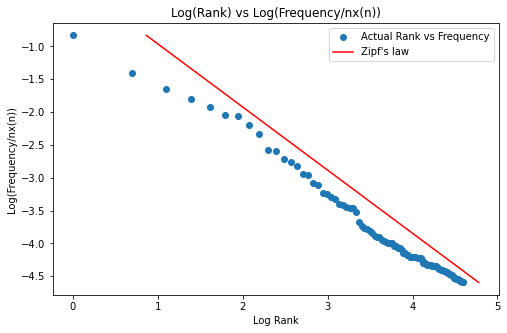

In [26]:
# Get the value of the denominator n*x_n
denominator = max(word_ranks)*min(top_word_series)

# Y variable is the log of word ranks and X is the word frequency divided by the denominator
# above
Y = np.array(np.log(word_ranks))
X = np.array(np.log(top_word_series/denominator))

# fit a linear regression to these, we dont need the intercept!
from sklearn import linear_model
reg_model = linear_model.LinearRegression(fit_intercept = False)
reg_model.fit(Y.reshape(-1,1), X)
print("The value of theta obtained is:",reg_model.coef_)

# make a plot of actual rank obtained vs theoretical rank expected
plt.figure(figsize = (8,5))
plt.scatter(Y, X, label = "Actual Rank vs Frequency")
plt.title('Log(Rank) vs Log(Frequency/nx(n))')
plt.xlabel('Log Rank')
plt.ylabel('Log(Frequency/nx(n))')

plt.plot(reg_model.predict(X.reshape(-1,1)), X, color = 'red', label = "Zipf's law")
plt.legend()

In [27]:
# import the necessary functions from the nltk library
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
# prepare corpus from the descriptions that dont have stopwords
corpus = " ".join(train['Clean_Full_Descriptions_no_stop'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)

# lemmatize these tokens
lemmatized_tokens = [lmtzr.lemmatize(token) for token in tokenized_corpus]

# word frequencies for the lemmatized tokens
fd = nltk.FreqDist(lemmatized_tokens)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 10 words only
top_words = top_words[:10]

top_words

[('data', 9744),
 ('experience', 5328),
 ('work', 3111),
 ('team', 3056),
 ('year', 2239),
 ('business', 2208),
 ('’', 2106),
 ('skill', 1663),
 ('development', 1447),
 ('solution', 1412)]

In [39]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [40]:
# import the necessary functions from the nltk library
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

# prepare corpus from the descriptions that dont have stopwords
corpus = " ".join(train['Clean_Full_Descriptions_no_stop'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)

# lemmatize these tokens
lemmatized_tokens = [lmtzr.lemmatize(token) for token in tokenized_corpus]

# word frequencies for the lemmatized tokens
fd = nltk.FreqDist(lemmatized_tokens)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 10 words only
top_words = top_words[:10]

top_words

[('data', 9744),
 ('experience', 5328),
 ('work', 3111),
 ('team', 3056),
 ('year', 2239),
 ('business', 2208),
 ('’', 2106),
 ('skill', 1663),
 ('development', 1447),
 ('solution', 1412)]

In [41]:
# get the 75th percentile value of salary!
sal_perc_75 = np.percentile(train['max_salary_year'], 75)

# make a new target variable that captures whether salary is high (1) or low (0)
train['Salary_Target'] = np.where(train['max_salary_year'] >= sal_perc_75, 1, 0)

In [42]:
train.head()

,title,company,description,source,location,min_salary,max_salary,min_salary_year,salary_type,max_salary_year,Clean_Full_Descriptions,Clean_Full_Descriptions_no_stop,Salary_Target
0,Data Engineer Technical Specialist,Peraton,**Peraton Overview** \nPeraton drives mission...,indeed.com,United States,"$146,000","$234,000",146,per year,234,\nperaton drives missions of consequence sp...,peraton drives missions consequence spanning g...,1
1,Software Engineer - Fullstack,Brigit3.8 ★,"Hi, we're Brigit! A holistic financial health ...",glassdoor.com,"New York, NY",$100K,$170K,100,per year,170,hi were brigit a holistic financial helping e...,hi brigit holistic financial helping every ame...,1
2,Data Scientist,LifeScale Analytics,"At Lifescale Analytics, we help achieve data-d...",glassdoor.com,"Eagan, MN",$87K,$119K,87,per year,119,at lifescale analytics we help achieve datadri...,lifescale analytics help achieve datadriven de...,0
3,Data Scientist (Exempt),Mercy3.5 ★,We're a Little Different\n\nOur mission is cle...,glassdoor.com,"Chesterfield, MO",$86K,$122K,86,per year,122,were a little different\n\nour mission is clea...,little different mission clear bring life heal...,0
4,Data Scientist,Praxis Precision Medicines2.6 ★,Data Scientist\nLocation: This position may be...,glassdoor.com,"Charlestown, MA",$80K,$90K,80,per year,90,data scientist\nlocation this position may be ...,data scientist location position may performed...,0


In [43]:
train.dtypes.value_counts()

object    10
int64      3
dtype: int64

In [44]:
train.isnull().sum()[train.isnull().sum()>0]

Series([], dtype: int64)

In [45]:
# this gives us the categorical variables and the number of unique entries in them!
train.select_dtypes('object').nunique(dropna = False)

title                              430
company                            730
description                        889
source                               2
location                           159
min_salary                         377
max_salary                         382
salary_type                          3
Clean_Full_Descriptions            889
Clean_Full_Descriptions_no_stop    882
dtype: int64

In [46]:
train['Salary_Target'].value_counts()/len(train)


0    0.746667
1    0.253333
Name: Salary_Target, dtype: float64

In [75]:
# Subset the columns required
columns_required = ['title', 'company', 'source', 'location', 'Salary_Target']
train_b1 = train.loc[:, columns_required]

# Convert the categorical variables to dummy variables
train_b1 = pd.get_dummies(train_b1)

# Lets separate the predictors from the target variable
columns_selected = train_b1.columns.values.tolist()
target_variable = ['Salary_Target']

# predictors are all variables except for the target variable
predictors = list(set(columns_selected) - set(target_variable))

# setup the model
from sklearn.naive_bayes import BernoulliNB

X = np.array(train_b1.loc[:,predictors])
print(X)
y = np.array(train_b1.loc[:,target_variable[0]])

# create test train splits 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

model = BernoulliNB()

# Fit the model and predict the output on the test data
model.fit(X_train, y_train)

# Predicted output
predicted = model.predict(X_test)

# Accuracy
from sklearn import metrics


print("Model Accuracy is:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, predicted))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Model Accuracy is: 0.8222222222222222
Area under the ROC curve: 0.5789473684210527
Confusion Matrix:
 [[142   0]
 [ 32   6]]


In [80]:
### Create a Pickle file using serialization 
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [81]:
import numpy as np

In [83]:
import pickle
import numpy as np

# Load the trained model from the Pickle file
with open("classifier.pkl", "rb") as file:
    model = pickle.load(file)

# Create a function to make predictions
def predict_salary(title, company, source, location):
    # Ensure the input features match the expected number of features (1321)
    num_features = 1321
    input_data = [0] * num_features  # Initialize with zeros

    # Assign values to the available features (title, company, source, location)
    input_data[0] = title
    input_data[1] = company
    input_data[2] = source
    input_data[3] = location

    # Make a prediction using the loaded model
    prediction = model.predict([input_data])

    # Return the prediction
    if prediction[0] == 1:
        return "Fake note"
    else:
        return "It's a Job note"

# Example usage
result = predict_salary(2, 3, 4, 1)
print(result)


It's a Bank note


In [70]:
# Lets lemmatize the job descriptions before we run the model
def text_lemmatizer(s):
    '''Given a description, this lemmatizes it'''
    tokenized_corpus = nltk.word_tokenize(s)
    
    # lemmatize
    s = " ".join([lmtzr.lemmatize(token) for token in tokenized_corpus])
    return s

# lemmatize the descriptions
train['Clean_Full_Descriptions_no_stop_lemm'] = train['Clean_Full_Descriptions_no_stop'].map(text_lemmatizer)
value_at_index_0 = train['Clean_Full_Descriptions_no_stop_lemm'][0]
print("Value at index 0:", type(value_at_index_0))
# print(train['Clean_Full_Descriptions_no_stop_lemm'])
# make the X and y matrices for model fitting
X = np.array(train.loc[:, 'Clean_Full_Descriptions_no_stop_lemm'])

y = np.array(train.loc[:, 'Salary_Target'])

# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# Convert the arrays into a presence/absence matrix
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
nb_mult_model = MultinomialNB().fit(X_train_counts, y_train)
predicted = nb_mult_model.predict(X_test_counts)

print("Model Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, predicted))

Value at index 0: <class 'str'>
Model Accuracy: 0.8166666666666667
Area under the ROC curve: 0.7392512972572275
Model Confusion Matrix:
 [[124  18]
 [ 15  23]]


In [58]:
# Calculate the frequencies of words using the TfidfTransformer
X_train_bern = np.where(X_train_counts.todense() > 0 , 1, 0)
X_test_bern = np.where(X_test_counts.todense() > 0, 1, 0)

# Fit the model
from sklearn.naive_bayes import BernoulliNB
nb_bern_model = BernoulliNB().fit(X_train_bern, y_train)


In [60]:
import numpy as np
predicted = nb_bern_model.predict(X_test_bern)

# print the accuracies
print("Model Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, predicted))

Model Accuracy: 0.8
Area under the ROC curve: 0.6515937731653076
Model Confusion Matrix:
 [[129  13]
 [ 23  15]]


In [54]:
# extract the column names for the columns in our training dataset.
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

# probability of high salary
p_1 = np.mean(y_train)

# probability of low salary
p_0 = 1 - p_1

# create an array of feature vectors
feature_vectors = np.array(X_train_bern)

# probability of word appearance
word_probabilities = np.mean(feature_vectors, axis = 0)

# probability of seeing these words for class= 1 and class = 0 respectively
p_x_1 = np.mean(feature_vectors[y_train==1, :], axis = 0)
p_x_0 = np.mean(feature_vectors[y_train==0, :], axis = 0)

# words that are good indicators of high salary (class = 1)
high_indicators = p_x_1 * (np.log2(p_x_1) - np.log2(word_probabilities) - np.log2(p_1))

high_indicators_series = pd.Series(high_indicators, index = column_names)

# words that are good indicators of low salary (class = 0)
low_indicators = p_x_0 * (np.log2(p_x_0) - np.log2(word_probabilities) - np.log2(p_0))

low_indicators_series = pd.Series(low_indicators, index = column_names)


In [55]:
low_indicators_series[[i for i in low_indicators_series.index if i not in en_stopwords]].sort_values(ascending = False)[:100].index

Index(['work', 'experience', 'data', 'skill', 'year', 'team', 'ability',
       'requirement', 'solution', 'development', 'business', 'technology',
       'sql', 'degree', 'job', 'required', 'knowledge', 'strong', 'develop',
       'support', 'bachelor', 'tool', 'system', 'database', 'analysis',
       'design', 'information', 'related', 'management', 'including',
       'process', 'analytics', 'position', 'working', 'opportunity', 'benefit',
       'using', 'provide', 'engineer', 'environment', 'science', 'project',
       'python', 'service', 'type', 'source', 'preferred', 'new',
       'application', 'education', 'responsibility', 'analyst', 'location',
       'software', 'employee', 'role', 'field', 'time', 'professional',
       'engineering', 'need', 'remote', 'hour', 'quality', 'schedule',
       'qualification', 'understand', 'technical', 'understanding', 'must',
       'health', 'analytical', 'performance', 'maintain', 'one', 'industry',
       'employer', 'report', 'andor', '

In [56]:
high_indicators_series[[i for i in high_indicators_series.index if i not in en_stopwords]].sort_values(ascending = False)[:100].index

Index(['experience', 'work', 'team', 'opportunity', 'year', 'role', 'data',
       'engineering', 'product', 'disability', 'range', 'science', 'business',
       'benefit', 'salary', 'including', 'may', 'location', 'build', 'working',
       'new', 'skill', 'building', 'equal', 'platform', 'people', 'learning',
       'status', 'help', 'environment', 'need', 'process', 'base', 'design',
       'time', 'degree', 'protected', 'also', 'python', 'across', 'make',
       'employee', 'age', 'race', 'pay', 'law', 'like', 'best', 'job',
       'development', 'gender', 'national', 'technical', 'factor', 'veteran',
       'candidate', 'medical', 'employer', 'applicable', 'color', 'system',
       'scientist', 'religion', 'position', 'origin', 'well', 'problem',
       'language', 'engineer', 'solution', 'world', 'support', 'sexual',
       'applicant', 'orientation', 'application', 'identity', 'impact',
       'field', 'based', 'employment', 'value', 'please', 'user', 'use',
       'technology',